In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

# VGG16 모델 로드 (include_top=False로 특징 추출용으로 사용)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 구성
model = Sequential()
model.add(base_model)

# 3차원 출력 -> 1차원 벡터로 변환 (Flatten 또는 GlobalAveragePooling2D 중 하나 사용)
model.add(GlobalAveragePooling2D())

# Dense 레이어에 L2 정규화 추가, 크기를 128로 설정
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))  # L2 정규화 강도를 0.05로 증가
model.add(BatchNormalization())  # Batch Normalization 추가
model.add(Dropout(0.7))  # Dropout 비율을 0.7로 증가시킴

# 이진 분류를 위한 출력층 (sigmoid 활성화 함수)
model.add(Dense(1, activation='sigmoid'))

# 기존 VGG16의 가중치를 고정 (마지막 6개 레이어만 학습 가능)
base_model.trainable = True
for layer in base_model.layers[:-6]:  # 학습 가능한 레이어 수를 줄여 더 적게 학습 가능하게 함
    layer.trainable = False

# 모델 컴파일 (학습률 낮춤)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # 학습률 1e-5로 설정
              metrics=['accuracy'])

# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=60,  # 회전 범위를 더 증가시킴
    width_shift_range=0.5,  # 가로 이동 범위를 증가
    height_shift_range=0.5,  # 세로 이동 범위를 증가
    shear_range=0.5,  # 왜곡 범위를 증가
    zoom_range=0.5,  # 확대 범위를 증가
    horizontal_flip=True,
    fill_mode='nearest'
)

# train set
train_generator = train_datagen.flow_from_directory(
    './data/train_added/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# validation set을 위한 ImageDataGenerator (증강 없이 rescale만)
valid_datagen = ImageDataGenerator(rescale=1/255)

# valid set
valid_generator = valid_datagen.flow_from_directory(
    './data/validation-horse-or-human/',
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary'
)

# 콜백 설정 (validation loss가 포함된지 확인)
es = EarlyStopping(
    monitor='val_loss',
    patience=5,  # patience 값을 5로 설정하여 더 빠르게 조기 종료
    verbose=1,
    restore_best_weights=True  # 최적의 가중치로 복원
)

checkpoint = ModelCheckpoint(
    filepath='./checkpoint.keras',
    monitor='val_loss',  # 'val_loss'를 모니터링하도록 설정
    verbose=2,
    save_best_only=True,
    mode='auto'
)

# 학습률 조정 콜백 (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # patience 값을 3으로 설정하여 더 빠르게 학습률 감소
    min_lr=1e-6,
    verbose=1
)

# steps_per_epoch 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,  # validation data 설정
    validation_steps=validation_steps,
    epochs=15,  # 에포크 수 설정
    verbose=1,
    callbacks=[checkpoint, es, reduce_lr]
)


Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5831 - loss: 11.0525
Epoch 1: val_loss improved from inf to 10.90289, saving model to ./checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - accuracy: 0.5844 - loss: 11.0501 - val_accuracy: 0.5000 - val_loss: 10.9029 - learning_rate: 1.0000e-05
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 699us/step - accuracy: 0.7500 - loss: 10.7241 - learning_rate: 1.0000e-05
Epoch 3/15


c:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7367 - loss: 10.6658
Epoch 3: val_loss improved from 10.90289 to 10.75247, saving model to ./checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.7373 - loss: 10.6643 - val_accuracy: 0.5000 - val_loss: 10.7525 - learning_rate: 1.0000e-05
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.8000 - loss: 10.4765 - learning_rate: 1.0000e-05
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7979 - loss: 10.4309
Epoch 5: val_loss improved from 10.75247 to 10.57243, saving model to ./checkpoint.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 232s 5s/step - accuracy: 0.7981 - loss: 10.4298 - val_accuracy: 0.5586 - val_loss: 10.5724 - learning_rate: 1.0000e-05
Epoch 6/15


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9042 - loss: 1.1657
test loss, test acc: [1.1550676822662354, 0.91015625]
['horse (1).jpg', 'horse (1).png', 'horse (10).jpg', 'horse (11).jpg', 'horse (12).jpg', 'horse (13).jpg', 'horse (14).jpg', 'horse (15).jpg', 'horse (16).jpg', 'horse (17).jpg', 'horse (18).jpg', 'horse (19).jpg', 'horse (2).jpg', 'horse (2).png', 'horse (20).jpg', 'horse (21).jpg', 'horse (22).jpg', 'horse (23).jpg', 'horse (24).jpg', 'horse (25).jpg', 'horse (26).jpg', 'horse (27).jpg', 'horse (28).jpg', 'horse (29).jpg', 'horse (3).jpg', 'horse (3).png', 'horse (30).jpg', 'horse (31).jpg', 'horse (32).jpg', 'horse (33).jpg', 'horse (34).jpg', 'horse (35).jpg', 'horse (36).jpg', 'horse (37).jpg', 'horse (38).jpg', 'horse (39).jpg', 'horse (4).jpg', 'horse (4).png', 'horse (40).jpg', 'horse (41).jpg', 'horse (42).jpg', 'horse (43).jpg', 'horse (44).jpg', 'horse (45).jpg', 'horse (46).jpg', 'horse (47).jpg', 'horse (48).jpg', 'horse (49).jpg', 'horse (5).jpg', '

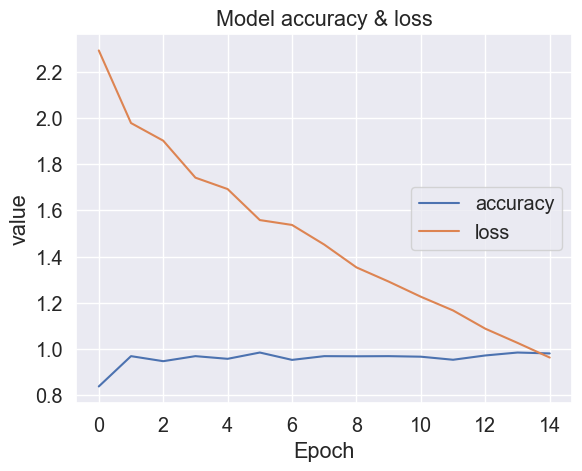

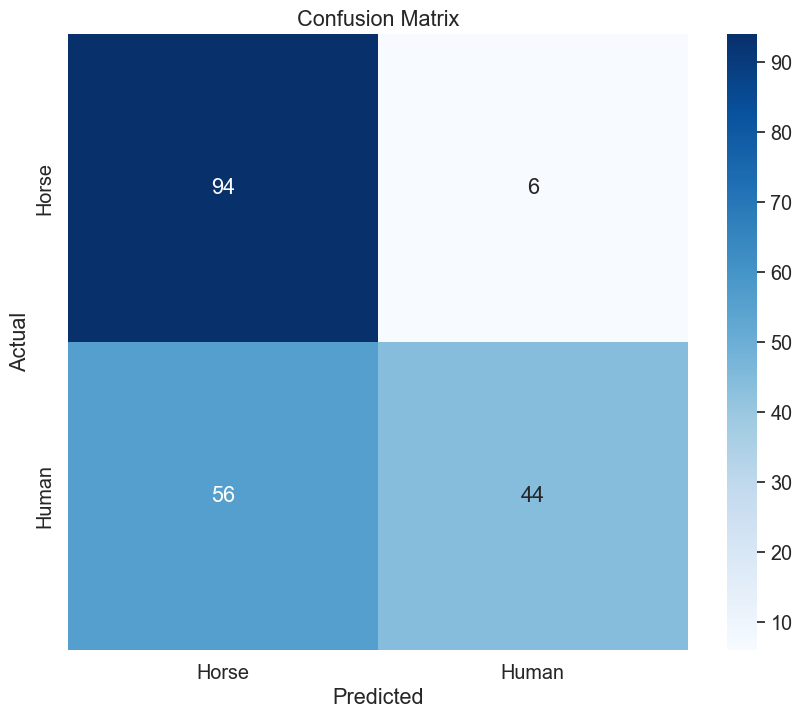

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)
# 이미지 전처리
dlist = './data/test/'
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (224,224)) for i in img]
img = np.array(img)
img = img.astype('float32') / 255.0

# 분류
cutoff = .5
predictions = model.predict(img)
print(predictions >= cutoff)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('value')
plt.legend(['accuracy', 'loss'], loc='center right')
plt.show()
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.3)


y_true = np.array([0]*100 + [1]*100)
y_pred = predictions
y_pred_classes = np.round(y_pred).astype(int).flatten()  # 예측값을 0 또는 1로 변환
# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred_classes)
# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Horse", "Human"],
    yticklabels=["Horse", "Human"],
)
plt.xlabel("Predicted" )
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [5]:
model.save('model2.keras')